In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.autograd import Variable
import numpy as np
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian, DiagGGNMC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
from LB_utils import * 
import time

import matplotlib.pyplot as plt

s = 127
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


In [4]:

class LPADirNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super(LPADirNN, self).__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Flatten()     
        )
        self.linear = torch.nn.Linear(4 * 4 * 64, num_classes) 

    def forward(self, x):
        out = self.features(x)
        out = self.linear(out)
        return out

def LPADirNN_last_layer(num_classes=10):
    return(LPADirNN(num_classes=num_classes))

In [5]:
BATCH_SIZE_TRAIN_MNIST = 128
BATCH_SIZE_TEST_MNIST = 128
MAX_ITER_MNIST = 6
LR_TRAIN_MNIST = 10e-6

In [6]:
MNIST_transform = torchvision.transforms.ToTensor()

MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)

mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=BATCH_SIZE_TRAIN_MNIST,
    shuffle=True
)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False,
)

In [7]:
mnist_model = LPADirNN_last_layer().cuda()
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
MNIST_PATH = "pretrained_weights/MNIST_pretrained_10_classes_last_layer_s{}.pth".format(s)

In [8]:
#Training routine

def train(model, train_loader, optimizer, max_iter, path, verbose=True):
    max_len = len(train_loader)

    for iter in range(max_iter):
        for batch_idx, (x, y) in enumerate(train_loader):
            
            x, y = x.cuda(), y.cuda()
            
            output = model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if verbose and batch_idx % 50 == 0:
                print(
                    "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                    "Minibatch Loss %.3f  " % (loss) +
                    "Accuracy %.0f" % (accuracy * 100) + "%"
                )

    print("saving model at: {}".format(path))
    torch.save(mnist_model.state_dict(), path)

In [9]:
train(mnist_model, mnist_train_loader, mnist_train_optimizer, MAX_ITER_MNIST, MNIST_PATH, verbose=True)

Iteration 0; 0/469 	Minibatch Loss 2.322  Accuracy 11%
Iteration 0; 50/469 	Minibatch Loss 0.326  Accuracy 91%
Iteration 0; 100/469 	Minibatch Loss 0.187  Accuracy 93%
Iteration 0; 150/469 	Minibatch Loss 0.188  Accuracy 97%
Iteration 0; 200/469 	Minibatch Loss 0.147  Accuracy 95%
Iteration 0; 250/469 	Minibatch Loss 0.378  Accuracy 92%
Iteration 0; 300/469 	Minibatch Loss 0.187  Accuracy 93%
Iteration 0; 350/469 	Minibatch Loss 0.086  Accuracy 97%
Iteration 0; 400/469 	Minibatch Loss 0.166  Accuracy 94%
Iteration 0; 450/469 	Minibatch Loss 0.052  Accuracy 98%
Iteration 1; 0/469 	Minibatch Loss 0.055  Accuracy 98%
Iteration 1; 50/469 	Minibatch Loss 0.080  Accuracy 96%
Iteration 1; 100/469 	Minibatch Loss 0.057  Accuracy 99%
Iteration 1; 150/469 	Minibatch Loss 0.083  Accuracy 97%
Iteration 1; 200/469 	Minibatch Loss 0.036  Accuracy 99%
Iteration 1; 250/469 	Minibatch Loss 0.066  Accuracy 98%
Iteration 1; 300/469 	Minibatch Loss 0.022  Accuracy 100%
Iteration 1; 350/469 	Minibatch Loss

In [10]:
#predict in distribution
MNIST_PATH = "pretrained_weights/MNIST_pretrained_10_classes_last_layer_s{}.pth".format(s)
#MNIST_PATH = "pretrained_weights/MNIST_pretrained_10_classes_last_layer.pth"

mnist_model = LPADirNN_last_layer().cuda()
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

acc = []

max_len = len(mnist_test_loader)
for batch_idx, (x, y) in enumerate(mnist_test_loader):

    x, y = x.cuda(), y.cuda()
    output = mnist_model(x)

    accuracy = get_accuracy(output, y)
    if batch_idx % 10 == 0:
        print(
            "Batch {}/{} \t".format(batch_idx, max_len) + 
            "Accuracy %.0f" % (accuracy * 100) + "%"
        )
    acc.append(accuracy)

avg_acc = np.mean(acc)
print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))


loading model from: pretrained_weights/MNIST_pretrained_10_classes_last_layer_s127.pth
Batch 0/79 	Accuracy 98%
Batch 10/79 	Accuracy 98%
Batch 20/79 	Accuracy 98%
Batch 30/79 	Accuracy 98%
Batch 40/79 	Accuracy 100%
Batch 50/79 	Accuracy 99%
Batch 60/79 	Accuracy 100%
Batch 70/79 	Accuracy 100%
overall test accuracy on MNIST: 98.94 %


In [11]:
BATCH_SIZE_TEST_FMNIST = 128
BATCH_SIZE_TEST_KMNIST = 128

In [12]:
FMNIST_test = torchvision.datasets.FashionMNIST(
        '~/data/fmnist', train=False, download=True,
        transform=MNIST_transform)   #torchvision.transforms.ToTensor())

FMNIST_test_loader = torch.utils.data.DataLoader(
    FMNIST_test,
    batch_size=BATCH_SIZE_TEST_FMNIST, shuffle=False)

In [13]:
KMNIST_test = torchvision.datasets.KMNIST(
        '~/data/kmnist', train=False, download=True,
        transform=MNIST_transform)

KMNIST_test_loader = torch.utils.data.DataLoader(
    KMNIST_test,
    batch_size=BATCH_SIZE_TEST_KMNIST, shuffle=False)

In [14]:
"""Load notMNIST"""

import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
from torch import Tensor

"""
Loads the train/test set. 
Every image in the dataset is 28x28 pixels and the labels are numbered from 0-9
for A-J respectively.
Set root to point to the Train/Test folders.
"""

# Creating a sub class of torch.utils.data.dataset.Dataset
class notMNIST(Dataset):

    # The init method is called when this class will be instantiated
    def __init__(self, root, transform):
        
        #super(notMNIST, self).__init__(root, transform=transform)

        self.transform = transform
        
        Images, Y = [], []
        folders = os.listdir(root)

        for folder in folders:
            folder_path = os.path.join(root, folder)
            for ims in os.listdir(folder_path):
                try:
                    img_path = os.path.join(folder_path, ims)
                    Images.append(np.array(imread(img_path)))
                    Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
                except:
                    # Some images in the dataset are damaged
                    print("File {}/{} is broken".format(folder, ims))
        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data
        self.targets = torch.Tensor(Y)

    # The number of items in the dataset
    def __len__(self):
        return len(self.data)

    # The Dataloader is a generator that repeatedly calls the getitem method.
    # getitem is supposed to return (X, Y) for the specified index.
    def __getitem__(self, index):
        img = self.data[index][0]

        if self.transform is not None:
            img = self.transform(img)
            
        # Input for Conv2D should be Channels x Height x Width
        img_tensor = Tensor(img).view(1, 28, 28).float()
        label = self.data[index][1]
        return (img_tensor, label)

In [15]:
#root = os.path.abspath('~/data')
root = os.path.expanduser('~/data')

# Instantiating the notMNIST dataset class we created
notMNIST_test = notMNIST(root=os.path.join(root, 'notMNIST_small'),
                               transform=MNIST_transform)

# Creating a dataloader
not_mnist_test_loader = torch.utils.data.dataloader.DataLoader(
                            dataset=notMNIST_test,
                            batch_size=BATCH_SIZE_TEST_KMNIST,
                            shuffle=False)

File F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is broken
File A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is broken


# Prepare Gaussians

In [16]:
t0 = time.time()
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=mnist_model,
                                                                   train_loader=mnist_train_loader,
                                                                   var0 = 1e-3,
                                                                   device=device)
t1 = time.time()
time_gaussian = t1-t0
print("preparing Gaussians took {} seconds which is {} minutes".format(time_gaussian, time_gaussian/60))

n: 1024 inputs to linear layer with m: 10 classes
Batch: 0/469
Batch: 1/469
Batch: 2/469
Batch: 3/469
Batch: 4/469
Batch: 5/469
Batch: 6/469
Batch: 7/469
Batch: 8/469
Batch: 9/469
Batch: 10/469
Batch: 11/469
Batch: 12/469
Batch: 13/469
Batch: 14/469
Batch: 15/469
Batch: 16/469
Batch: 17/469
Batch: 18/469
Batch: 19/469
Batch: 20/469
Batch: 21/469
Batch: 22/469
Batch: 23/469
Batch: 24/469
Batch: 25/469
Batch: 26/469
Batch: 27/469
Batch: 28/469
Batch: 29/469
Batch: 30/469
Batch: 31/469
Batch: 32/469
Batch: 33/469
Batch: 34/469
Batch: 35/469
Batch: 36/469
Batch: 37/469
Batch: 38/469
Batch: 39/469
Batch: 40/469
Batch: 41/469
Batch: 42/469
Batch: 43/469
Batch: 44/469
Batch: 45/469
Batch: 46/469
Batch: 47/469
Batch: 48/469
Batch: 49/469
Batch: 50/469
Batch: 51/469
Batch: 52/469
Batch: 53/469
Batch: 54/469
Batch: 55/469
Batch: 56/469
Batch: 57/469
Batch: 58/469
Batch: 59/469
Batch: 60/469
Batch: 61/469
Batch: 62/469
Batch: 63/469
Batch: 64/469
Batch: 65/469
Batch: 66/469
Batch: 67/469
Batch: 6

In [17]:
M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K = KFLP_second_order(model=mnist_model,
                                                               train_loader=mnist_train_loader,
                                                               var0 = 5e-2,
                                                               device=device)

Batch: 0/469
Batch: 1/469
Batch: 2/469
Batch: 3/469
Batch: 4/469
Batch: 5/469
Batch: 6/469
Batch: 7/469
Batch: 8/469
Batch: 9/469
Batch: 10/469
Batch: 11/469
Batch: 12/469
Batch: 13/469
Batch: 14/469
Batch: 15/469
Batch: 16/469
Batch: 17/469
Batch: 18/469
Batch: 19/469
Batch: 20/469
Batch: 21/469
Batch: 22/469
Batch: 23/469
Batch: 24/469
Batch: 25/469
Batch: 26/469
Batch: 27/469
Batch: 28/469
Batch: 29/469
Batch: 30/469
Batch: 31/469
Batch: 32/469
Batch: 33/469
Batch: 34/469
Batch: 35/469
Batch: 36/469
Batch: 37/469
Batch: 38/469
Batch: 39/469
Batch: 40/469
Batch: 41/469
Batch: 42/469
Batch: 43/469
Batch: 44/469
Batch: 45/469
Batch: 46/469
Batch: 47/469
Batch: 48/469
Batch: 49/469
Batch: 50/469
Batch: 51/469
Batch: 52/469
Batch: 53/469
Batch: 54/469
Batch: 55/469
Batch: 56/469
Batch: 57/469
Batch: 58/469
Batch: 59/469
Batch: 60/469
Batch: 61/469
Batch: 62/469
Batch: 63/469
Batch: 64/469
Batch: 65/469
Batch: 66/469
Batch: 67/469
Batch: 68/469
Batch: 69/469
Batch: 70/469
Batch: 71/469
Ba

# MAP estimate

In [18]:
targets = MNIST_test.targets.numpy()
targets_FMNIST = FMNIST_test.targets.numpy()
targets_notMNIST = notMNIST_test.targets.numpy().astype(int)
targets_KMNIST = KMNIST_test.targets.numpy()

In [19]:
mnist_test_in_MAP = predict_MAP(mnist_model, mnist_test_loader, cuda=True).cpu().numpy()
mnist_test_out_fmnist_MAP = predict_MAP(mnist_model, FMNIST_test_loader, cuda=True).cpu().numpy()
mnist_test_out_notMNIST_MAP = predict_MAP(mnist_model, not_mnist_test_loader, cuda=True).cpu().numpy()
mnist_test_out_KMNIST_MAP = predict_MAP(mnist_model, KMNIST_test_loader, cuda=True).cpu().numpy()

In [20]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(mnist_test_in_MAP, targets)
acc_out_FMNIST_MAP, prob_correct_out_FMNIST_MAP, ent_out_FMNIST_MAP, MMC_out_FMNIST_MAP, auroc_out_FMNIST_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_fmnist_MAP, targets_FMNIST)
acc_out_notMNIST_MAP, prob_correct_out_notMNIST_MAP, ent_out_notMNIST_MAP, MMC_out_notMNIST_MAP, auroc_out_notMNIST_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_notMNIST_MAP, targets_notMNIST)
acc_out_KMNIST_MAP, prob_correct_out_KMNIST_MAP, ent_out_KMNIST_MAP, MMC_out_KMNIST_MAP, auroc_out_KMNIST_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_KMNIST_MAP, targets_KMNIST)

In [21]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'mnist', 'MAP')
print_out_dist_values(acc_out_FMNIST_MAP, prob_correct_out_FMNIST_MAP, ent_out_FMNIST_MAP, MMC_out_FMNIST_MAP, auroc_out_FMNIST_MAP, 'FMNIST', 'MAP')
print_out_dist_values(acc_out_notMNIST_MAP, prob_correct_out_notMNIST_MAP, ent_out_notMNIST_MAP, MMC_out_notMNIST_MAP, auroc_out_notMNIST_MAP, 'notMNIST', 'MAP')
print_out_dist_values(acc_out_KMNIST_MAP, prob_correct_out_KMNIST_MAP, ent_out_KMNIST_MAP, MMC_out_KMNIST_MAP, auroc_out_KMNIST_MAP, 'KMNIST', 'MAP')

[In, MAP, mnist] Accuracy: 0.989; average entropy: 0.040;     MMC: 0.988; Prob @ correct: 0.100
[Out-MAP, KFAC, FMNIST] Accuracy: 0.096; Average entropy: 1.166;    MMC: 0.581; AUROC: 0.988; Prob @ correct: 0.100
[Out-MAP, KFAC, notMNIST] Accuracy: 0.145; Average entropy: 0.588;    MMC: 0.783; AUROC: 0.923; Prob @ correct: 0.100
[Out-MAP, KFAC, KMNIST] Accuracy: 0.085; Average entropy: 0.769;    MMC: 0.718; AUROC: 0.968; Prob @ correct: 0.100


In [22]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.989, 0.989, 0.991, 0.988, 0.989]
mmc_in = [0.988, 0.986, 0.988, 0.988, 0.988]
mmc_out_fmnist = [0.591, 0.604, 0.543, 0.600, 0.581]
mmc_out_notmnist = [0.750, 0.777, 0.775, 0.782, 0.783]
mmc_out_kmnist = [0.717, 0.732, 0.721, 0.725, 0.718]

auroc_out_fmnist = [0.988, 0.984, 0.991, 0.986, 0.988]
auroc_out_notmnist = [0.947, 0.914, 0.937, 0.931, 0.923]
auroc_out_kmnist = [0.969, 0.962, 0.968, 0.968, 0.968]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out fmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_fmnist), np.std(mmc_out_fmnist)))
print("MMC out notmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_notmnist), np.std(mmc_out_notmnist)))
print("MMC out kmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_kmnist), np.std(mmc_out_kmnist)))

print("AUROC out fmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_fmnist), np.std(auroc_out_fmnist)))
print("AUROC out notmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_notmnist), np.std(auroc_out_notmnist)))
print("AUROC out kmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_kmnist), np.std(auroc_out_kmnist)))

accuracy: 0.989 with std 0.001
MMC in: 0.988 with std 0.001
MMC out fmnist: 0.584 with std 0.022
MMC out notmnist: 0.773 with std 0.012
MMC out kmnist: 0.723 with std 0.005
AUROC out fmnist: 0.987 with std 0.002
AUROC out notmnist: 0.930 with std 0.011
AUROC out kmnist: 0.967 with std 0.003


In [23]:
num_samples = 1000

# Diag Hessian Sampling estimate

In [24]:
mnist_test_in_D = predict_diagonal_sampling(mnist_model, mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()
mnist_test_out_FMNIST_D = predict_diagonal_sampling(mnist_model, FMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()
mnist_test_out_notMNIST_D = predict_diagonal_sampling(mnist_model, not_mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()
mnist_test_out_KMNIST_D = predict_diagonal_sampling(mnist_model, KMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()

time used for sampling with 1000 samples: 6.933193206787109
time used for sampling with 1000 samples: 9.217273950576782
time used for sampling with 1000 samples: 15.104217767715454
time used for sampling with 1000 samples: 8.084147930145264


In [25]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(mnist_test_in_D, targets)
acc_out_FMNIST_D, prob_correct_out_FMNIST_D, ent_out_FMNIST_D, MMC_out_FMNIST_D, auroc_out_FMNIST_D = get_out_dist_values(mnist_test_in_D, mnist_test_out_FMNIST_D, targets_FMNIST)
acc_out_notMNIST_D, prob_correct_out_notMNIST_D, ent_out_notMNIST_D, MMC_out_notMNIST_D, auroc_out_notMNIST_D = get_out_dist_values(mnist_test_in_D, mnist_test_out_notMNIST_D, targets_notMNIST)
acc_out_KMNIST_D, prob_correct_out_KMNIST_D, ent_out_KMNIST_D, MMC_out_KMNIST_D, auroc_out_KMNIST_D = get_out_dist_values(mnist_test_in_D, mnist_test_out_KMNIST_D, targets_KMNIST)

In [26]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'MNIST', 'Diag')
print_out_dist_values(acc_out_FMNIST_D, prob_correct_out_FMNIST_D, ent_out_FMNIST_D, MMC_out_FMNIST_D, auroc_out_FMNIST_D, 'MNIST', test='fmnist', method='Diag')
print_out_dist_values(acc_out_notMNIST_D, prob_correct_out_notMNIST_D, ent_out_notMNIST_D, MMC_out_notMNIST_D, auroc_out_notMNIST_D, 'MNIST', test='notMNIST', method='Diag')
print_out_dist_values(acc_out_KMNIST_D, prob_correct_out_KMNIST_D, ent_out_KMNIST_D, MMC_out_KMNIST_D, auroc_out_KMNIST_D, 'MNIST', test='KMNIST', method='Diag')

[In, Diag, MNIST] Accuracy: 0.989; average entropy: 0.073;     MMC: 0.979; Prob @ correct: 0.100
[Out-fmnist, Diag, MNIST] Accuracy: 0.097; Average entropy: 1.242;    MMC: 0.550; AUROC: 0.985; Prob @ correct: 0.100
[Out-notMNIST, Diag, MNIST] Accuracy: 0.145; Average entropy: 0.721;    MMC: 0.731; AUROC: 0.921; Prob @ correct: 0.100
[Out-KMNIST, Diag, MNIST] Accuracy: 0.085; Average entropy: 0.929;    MMC: 0.654; AUROC: 0.966; Prob @ correct: 0.100


In [27]:
#Diag Sampling (1000)
#seeds are 123,124,125,126,127
time_diag_in = [7.236505508422852, 7.125160217285156, 7.238185882568359, 7.385348320007324, 7.000167608261108]
time_diag_out_fmnist = [7.219660520553589, 8.032358407974243, 7.777910232543945, 7.446442604064941, 7.200972318649292]
time_diag_out_notmnist = [20.68891930580139, 19.327053546905518, 18.424328804016113, 17.584392786026, 17.085043907165527]
time_diag_out_kmnist = [9.627353191375732, 9.133541345596313, 9.307446718215942, 9.410037755966187, 9.100234746932983]

acc_in = [0.989, 0.989, 0.990, 0.988, 0.989]
mmc_in = [0.980, 0.976, 0.979, 0.980, 0.979]
mmc_out_fmnist = [0.558, 0.570, 0.511, 0.566, 0.550]
mmc_out_notmnist = [0.695, 0.730, 0.721, 0.735, 0.731]
mmc_out_kmnist = [0.653, 0.666, 0.654, 0.664, 0.654]

auroc_out_fmnist = [0.985, 0.980, 0.988, 0.983, 0.985]
auroc_out_notmnist = [0.944, 0.907, 0.935, 0.927, 0.921]
auroc_out_kmnist = [0.968, 0.960, 0.967, 0.966, 0.966]

print("Diagonal Sampling time in: {:.03f} with std {:.03f}".format(np.mean(time_diag_in), np.std(time_diag_in)))
print("Diagonal Sampling time out fmnist: {:.03f} with std {:.03f}".format(np.mean(time_diag_out_fmnist), np.std(time_diag_out_fmnist)))
print("Diagonal Sampling time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_diag_out_notmnist), np.std(time_diag_out_notmnist)))
print("Diagonal Sampling time out kmnist: {:.03f} with std {:.03f}".format(np.mean(time_diag_out_kmnist), np.std(time_diag_out_kmnist)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out fmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_fmnist), np.std(mmc_out_fmnist)))
print("MMC out notmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_notmnist), np.std(mmc_out_notmnist)))
print("MMC out kmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_kmnist), np.std(mmc_out_kmnist)))

print("AUROC out fmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_fmnist), np.std(auroc_out_fmnist)))
print("AUROC out notmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_notmnist), np.std(auroc_out_notmnist)))
print("AUROC out kmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_kmnist), np.std(auroc_out_kmnist)))

Diagonal Sampling time in: 7.197 with std 0.129
Diagonal Sampling time out fmnist: 7.535 with std 0.324
Diagonal Sampling time out notmnist: 18.622 with std 1.284
Diagonal Sampling time out kmnist: 9.316 with std 0.193
accuracy: 0.989 with std 0.001
MMC in: 0.979 with std 0.001
MMC out fmnist: 0.551 with std 0.021
MMC out notmnist: 0.722 with std 0.014
MMC out kmnist: 0.658 with std 0.006
AUROC out fmnist: 0.984 with std 0.003
AUROC out notmnist: 0.927 with std 0.013
AUROC out kmnist: 0.965 with std 0.003


# KFAC Laplace Approximation (sampling)

In [28]:
mnist_test_in_KFAC = predict_KFAC_sampling(mnist_model, mnist_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()
mnist_test_out_FMNIST_KFAC = predict_KFAC_sampling(mnist_model, FMNIST_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()
mnist_test_out_notMNIST_KFAC = predict_KFAC_sampling(mnist_model, not_mnist_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()
mnist_test_out_KMNIST_KFAC = predict_KFAC_sampling(mnist_model, KMNIST_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True, n_samples=num_samples).cpu().numpy()

time used for sampling with 1000 samples: 7.918366432189941
time used for sampling with 1000 samples: 7.991961479187012
time used for sampling with 1000 samples: 15.196676015853882
time used for sampling with 1000 samples: 8.180310726165771


In [29]:
acc_in_KFAC, prob_correct_in_KFAC, ent_in_KFAC, MMC_in_KFAC = get_in_dist_values(mnist_test_in_KFAC, targets)
acc_out_FMNIST_KFAC, prob_correct_out_FMNIST_KFAC, ent_out_FMNIST_KFAC, MMC_out_FMNIST_KFAC, auroc_out_FMNIST_KFAC = get_out_dist_values(mnist_test_in_KFAC, mnist_test_out_FMNIST_KFAC, targets_FMNIST)
acc_out_notMNIST_KFAC, prob_correct_out_notMNIST_KFAC, ent_out_notMNIST_KFAC, MMC_out_notMNIST_KFAC, auroc_out_notMNIST_KFAC = get_out_dist_values(mnist_test_in_KFAC, mnist_test_out_notMNIST_KFAC, targets_notMNIST)
acc_out_KMNIST_KFAC, prob_correct_out_KMNIST_KFAC, ent_out_KMNIST_KFAC, MMC_out_KMNIST_KFAC, auroc_out_KMNIST_KFAC = get_out_dist_values(mnist_test_in_KFAC, mnist_test_out_KMNIST_KFAC, targets_KMNIST)

In [30]:
print_in_dist_values(acc_in_KFAC, prob_correct_in_KFAC, ent_in_KFAC, MMC_in_KFAC, 'MNIST', 'KFAC')
print_out_dist_values(acc_out_FMNIST_KFAC, prob_correct_out_FMNIST_KFAC, ent_out_FMNIST_KFAC, MMC_out_FMNIST_KFAC, auroc_out_FMNIST_KFAC, 'MNIST', test='fmnist', method='KFAC')
print_out_dist_values(acc_out_notMNIST_KFAC, prob_correct_out_notMNIST_KFAC, ent_out_notMNIST_KFAC, MMC_out_notMNIST_KFAC, auroc_out_notMNIST_KFAC, 'MNIST', test='notMNIST', method='KFAC')
print_out_dist_values(acc_out_KMNIST_KFAC, prob_correct_out_KMNIST_KFAC, ent_out_KMNIST_KFAC, MMC_out_KMNIST_KFAC, auroc_out_KMNIST_KFAC, 'MNIST', test='KMNIST', method='KFAC')

[In, KFAC, MNIST] Accuracy: 0.990; average entropy: 0.153;     MMC: 0.957; Prob @ correct: 0.100
[Out-fmnist, KFAC, MNIST] Accuracy: 0.098; Average entropy: 1.578;    MMC: 0.426; AUROC: 0.991; Prob @ correct: 0.100
[Out-notMNIST, KFAC, MNIST] Accuracy: 0.145; Average entropy: 1.320;    MMC: 0.525; AUROC: 0.972; Prob @ correct: 0.100
[Out-KMNIST, KFAC, MNIST] Accuracy: 0.086; Average entropy: 1.460;    MMC: 0.463; AUROC: 0.986; Prob @ correct: 0.100


# Laplace Bridge

In [31]:
mnist_test_in_LB = predict_LB(mnist_model, mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_FMNIST_LB = predict_LB(mnist_model, FMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_notMNIST_LB = predict_LB(mnist_model, not_mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_KMNIST_LB = predict_LB(mnist_model, KMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()

total time used for forward pass: 0.26442
total time used for Laplace Bridge: 0.01611
total time used for forward pass: 0.27728
total time used for Laplace Bridge: 0.01674
total time used for forward pass: 0.50956
total time used for Laplace Bridge: 0.03015
total time used for forward pass: 0.27605
total time used for Laplace Bridge: 0.01651


In [32]:
mnist_test_in_LBn = mnist_test_in_LB/mnist_test_in_LB.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_LBn = mnist_test_out_FMNIST_LB/mnist_test_out_FMNIST_LB.sum(1).reshape(-1,1)
mnist_test_out_notMNIST_LBn = mnist_test_out_notMNIST_LB/mnist_test_out_notMNIST_LB.sum(1).reshape(-1,1)
mnist_test_out_KMNIST_LBn = mnist_test_out_KMNIST_LB/mnist_test_out_KMNIST_LB.sum(1).reshape(-1,1)

In [33]:
acc_in_LBn, prob_correct_in_LBn, ent_in_LBn, MMC_in_LBn = get_in_dist_values(mnist_test_in_LBn, targets)
acc_out_FMNIST_LBn, prob_correct_out_FMNIST_LBn, ent_out_FMNIST_LBn, MMC_out_FMNIST_LBn, auroc_out_FMNIST_LBn = get_out_dist_values(mnist_test_in_LBn, mnist_test_out_FMNIST_LBn, targets_FMNIST)
acc_out_notMNIST_LBn, prob_correct_out_notMNIST_LBn, ent_out_notMNIST_LBn, MMC_out_notMNIST_LBn, auroc_out_notMNIST_LBn = get_out_dist_values(mnist_test_in_LBn, mnist_test_out_notMNIST_LBn, targets_notMNIST)
acc_out_KMNIST_LBn, prob_correct_out_KMNIST_LBn, ent_out_KMNIST_LBn, MMC_out_KMNIST_LBn, auroc_out_KMNIST_LBn = get_out_dist_values(mnist_test_in_LBn, mnist_test_out_KMNIST_LBn, targets_KMNIST)

In [34]:
print_in_dist_values(acc_in_LBn, prob_correct_in_LBn, ent_in_LBn, MMC_in_LBn, 'MNIST', 'LBn')
print_out_dist_values(acc_out_FMNIST_LBn, prob_correct_out_FMNIST_LBn, ent_out_FMNIST_LBn, MMC_out_FMNIST_LBn, auroc_out_FMNIST_LBn, 'MNIST', test='fmnist', method='LBn')
print_out_dist_values(acc_out_notMNIST_LBn, prob_correct_out_notMNIST_LBn, ent_out_notMNIST_LBn, MMC_out_notMNIST_LBn, auroc_out_notMNIST_LBn, 'MNIST', test='notMNIST', method='LBn')
print_out_dist_values(acc_out_KMNIST_LBn, prob_correct_out_KMNIST_LBn, ent_out_KMNIST_LBn, MMC_out_KMNIST_LBn, auroc_out_KMNIST_LBn, 'MNIST', test='KMNIST', method='LBn')

[In, LBn, MNIST] Accuracy: 0.989; average entropy: 0.042;     MMC: 0.988; Prob @ correct: 0.100
[Out-fmnist, LBn, MNIST] Accuracy: 0.096; Average entropy: 1.497;    MMC: 0.488; AUROC: 0.990; Prob @ correct: 0.100
[Out-notMNIST, LBn, MNIST] Accuracy: 0.145; Average entropy: 0.645;    MMC: 0.769; AUROC: 0.924; Prob @ correct: 0.100
[Out-KMNIST, LBn, MNIST] Accuracy: 0.085; Average entropy: 0.842;    MMC: 0.703; AUROC: 0.968; Prob @ correct: 0.100


In [35]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.01302, 0.01731, 0.01489, 0.01529, 0.01574]
time_lpb_out_fmnist = [0.01256, 0.01531, 0.01669, 0.01703, 0.01500]
time_lpb_out_notmnist = [0.02332, 0.03115, 0.02666, 0.02756, 0.02864]
time_lpb_out_kmnist = [0.01287, 0.01520, 0.01636, 0.01687, 0.01438]

acc_in = [0.989, 0.989, 0.991, 0.988, 0.989]
mmc_in = [0.988, 0.986, 0.988, 0.988, 0.988]
mmc_out_fmnist = [0.493, 0.523, 0.433, 0.514, 0.488]
mmc_out_notmnist = [0.735, 0.759, 0.756, 0.767, 0.769]
mmc_out_kmnist = [0.699, 0.722, 0.707, 0.713, 0.703]

auroc_out_fmnist = [0.991, 0.988, 0.993, 0.989, 0.990]
auroc_out_notmnist = [0.948, 0.915, 0.938, 0.932, 0.924]
auroc_out_kmnist = [0.970, 0.963, 0.969, 0.968, 0.968]

print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out fmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_fmnist), np.std(time_lpb_out_fmnist)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_notmnist), np.std(time_lpb_out_notmnist)))
print("Laplace Bridge time out kmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_kmnist), np.std(time_lpb_out_kmnist)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out fmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_fmnist), np.std(mmc_out_fmnist)))
print("MMC out notmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_notmnist), np.std(mmc_out_notmnist)))
print("MMC out kmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_kmnist), np.std(mmc_out_kmnist)))

print("AUROC out fmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_fmnist), np.std(auroc_out_fmnist)))
print("AUROC out notmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_notmnist), np.std(auroc_out_notmnist)))
print("AUROC out kmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_kmnist), np.std(auroc_out_kmnist)))

Laplace Bridge time in: 0.015 with std 0.001
Laplace Bridge time out fmnist: 0.015 with std 0.002
Laplace Bridge time out notmnist: 0.027 with std 0.003
Laplace Bridge time out kmnist: 0.015 with std 0.001
accuracy: 0.989 with std 0.001
MMC in: 0.988 with std 0.001
MMC out fmnist: 0.490 with std 0.031
MMC out notmnist: 0.757 with std 0.012
MMC out kmnist: 0.709 with std 0.008
AUROC out fmnist: 0.990 with std 0.002
AUROC out notmnist: 0.931 with std 0.011
AUROC out kmnist: 0.968 with std 0.002


# KFAC Laplace Bridge

In [36]:
mnist_test_in_LB_KFAC = predict_LB_KFAC(mnist_model, mnist_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_FMNIST_LB_KFAC = predict_LB_KFAC(mnist_model, FMNIST_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_notMNIST_LB_KFAC = predict_LB_KFAC(mnist_model, not_mnist_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_KMNIST_LB_KFAC = predict_LB_KFAC(mnist_model, KMNIST_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, verbose=False, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01399
total time used for transform: 0.01499
total time used for transform: 0.02830
total time used for transform: 0.01389


In [37]:
mnist_test_in_LB_KFACn = mnist_test_in_LB_KFAC/mnist_test_in_LB_KFAC.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_LB_KFACn = mnist_test_out_FMNIST_LB_KFAC/mnist_test_out_FMNIST_LB_KFAC.sum(1).reshape(-1,1)
mnist_test_out_notMNIST_LB_KFACn = mnist_test_out_notMNIST_LB_KFAC/mnist_test_out_notMNIST_LB_KFAC.sum(1).reshape(-1,1)
mnist_test_out_KMNIST_LB_KFACn = mnist_test_out_KMNIST_LB_KFAC/mnist_test_out_KMNIST_LB_KFAC.sum(1).reshape(-1,1)

In [38]:
acc_in_LB_KFACn, prob_correct_in_LB_KFACn, ent_in_LB_KFACn, MMC_in_LB_KFACn = get_in_dist_values(mnist_test_in_LB_KFACn, targets)
acc_out_FMNIST_LB_KFACn, prob_correct_out_FMNIST_LB_KFACn, ent_out_FMNIST_LB_KFACn, MMC_out_FMNIST_LB_KFACn, auroc_out_FMNIST_LB_KFACn = get_out_dist_values(mnist_test_in_LB_KFACn, mnist_test_out_FMNIST_LB_KFACn, targets_FMNIST)
acc_out_notMNIST_LB_KFACn, prob_correct_out_notMNIST_LB_KFACn, ent_out_notMNIST_LB_KFACn, MMC_out_notMNIST_LB_KFACn, auroc_out_notMNIST_LB_KFACn = get_out_dist_values(mnist_test_in_LB_KFACn, mnist_test_out_notMNIST_LB_KFACn, targets_notMNIST)
acc_out_KMNIST_LB_KFACn, prob_correct_out_KMNIST_LB_KFACn, ent_out_KMNIST_LB_KFACn, MMC_out_KMNIST_LB_KFACn, auroc_out_KMNIST_LB_KFACn = get_out_dist_values(mnist_test_in_LB_KFACn, mnist_test_out_KMNIST_LB_KFACn, targets_KMNIST)

In [39]:
print_in_dist_values(acc_in_LB_KFACn, prob_correct_in_LB_KFACn, ent_in_LB_KFACn, MMC_in_LB_KFACn, 'MNIST', 'LB_KFACn')
print_out_dist_values(acc_out_FMNIST_LB_KFACn, prob_correct_out_FMNIST_LB_KFACn, ent_out_FMNIST_LB_KFACn, MMC_out_FMNIST_LB_KFACn, auroc_out_FMNIST_LB_KFACn, 'MNIST', test='fmnist', method='LB_KFACn')
print_out_dist_values(acc_out_notMNIST_LB_KFACn, prob_correct_out_notMNIST_LB_KFACn, ent_out_notMNIST_LB_KFACn, MMC_out_notMNIST_LB_KFACn, auroc_out_notMNIST_LB_KFACn, 'MNIST', test='notMNIST', method='LB_KFACn')
print_out_dist_values(acc_out_KMNIST_LB_KFACn, prob_correct_out_KMNIST_LB_KFACn, ent_out_KMNIST_LB_KFACn, MMC_out_KMNIST_LB_KFACn, auroc_out_KMNIST_LB_KFACn, 'MNIST', test='KMNIST', method='LB_KFACn')

[In, LB_KFACn, MNIST] Accuracy: 0.989; average entropy: 0.042;     MMC: 0.988; Prob @ correct: 0.100
[Out-fmnist, LB_KFACn, MNIST] Accuracy: 0.096; Average entropy: 1.497;    MMC: 0.488; AUROC: 0.990; Prob @ correct: 0.100
[Out-notMNIST, LB_KFACn, MNIST] Accuracy: 0.145; Average entropy: 0.645;    MMC: 0.769; AUROC: 0.924; Prob @ correct: 0.100
[Out-KMNIST, LB_KFACn, MNIST] Accuracy: 0.085; Average entropy: 0.842;    MMC: 0.703; AUROC: 0.968; Prob @ correct: 0.100


In [40]:
#Laplace Bridge KFAC
#seeds are 123,124,125,126,127
time_lpb_in = [0.01302, 0.01731, 0.01489, 0.01529, 0.01574]
time_lpb_out_fmnist = [0.01256, 0.01531, 0.01669, 0.01703, 0.01500]
time_lpb_out_notmnist = [0.02332, 0.03115, 0.02666, 0.02756, 0.02864]
time_lpb_out_kmnist = [0.01287, 0.01520, 0.01636, 0.01687, 0.01438]

acc_in = [0.989, 0.989, 0.991, 0.988, 0.989]
mmc_in = [0.988, 0.986, 0.988, 0.988, 0.988]
mmc_out_fmnist = [0.493, 0.523, 0.433, 0.514, 0.488]
mmc_out_notmnist = [0.735, 0.759, 0.756, 0.767, 0.769]
mmc_out_kmnist = [0.699, 0.722, 0.707, 0.713, 0.703]

auroc_out_fmnist = [0.991, 0.988, 0.993, 0.989, 0.990]
auroc_out_notmnist = [0.948, 0.915, 0.938, 0.932, 0.924]
auroc_out_kmnist = [0.970, 0.963, 0.969, 0.968, 0.968]

print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out fmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_fmnist), np.std(time_lpb_out_fmnist)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_notmnist), np.std(time_lpb_out_notmnist)))
print("Laplace Bridge time out kmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_kmnist), np.std(time_lpb_out_kmnist)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out fmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_fmnist), np.std(mmc_out_fmnist)))
print("MMC out notmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_notmnist), np.std(mmc_out_notmnist)))
print("MMC out kmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_kmnist), np.std(mmc_out_kmnist)))

print("AUROC out fmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_fmnist), np.std(auroc_out_fmnist)))
print("AUROC out notmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_notmnist), np.std(auroc_out_notmnist)))
print("AUROC out kmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_kmnist), np.std(auroc_out_kmnist)))

Laplace Bridge time in: 0.015 with std 0.001
Laplace Bridge time out fmnist: 0.015 with std 0.002
Laplace Bridge time out notmnist: 0.027 with std 0.003
Laplace Bridge time out kmnist: 0.015 with std 0.001
accuracy: 0.989 with std 0.001
MMC in: 0.988 with std 0.001
MMC out fmnist: 0.490 with std 0.031
MMC out notmnist: 0.757 with std 0.012
MMC out kmnist: 0.709 with std 0.008
AUROC out fmnist: 0.990 with std 0.002
AUROC out notmnist: 0.931 with std 0.011
AUROC out kmnist: 0.968 with std 0.002


# Conditions

Test the condition derived in Proposition 1 of the paper and evaluated experimentally in Appendix A

In [41]:
# check if condition holds

def check_condition(alpha_vecs):
    #note that this is vectorized
    alpha_sum = alpha_vecs.sum(1)
    alpha_max = alpha_vecs.max(1)
    alpha_sum_minus = alpha_sum - alpha_max
    right_side = 0.25 * (np.sqrt(9 * alpha_sum_minus**2 + 10 * alpha_sum_minus + 1) - alpha_sum_minus - 1)
    cases = alpha_max > right_side
    percentage = np.sum(cases)/len(cases)
    return(percentage)

In [42]:
print(np.sum(check_condition(mnist_test_in_LB)))
print(np.sum(check_condition(mnist_test_out_FMNIST_LB)))
print(np.sum(check_condition(mnist_test_out_notMNIST_LB)))
print(np.sum(check_condition(mnist_test_out_KMNIST_LB)))

1.0
0.6661
0.9439756462294382
0.9462


# Compare to extended MacKay approach

In [43]:
mnist_test_in_EMK = predict_extended_MacKay(mnist_model, mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_FMNIST_EMK = predict_extended_MacKay(mnist_model, FMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_notMNIST_EMK = predict_extended_MacKay(mnist_model, not_mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_KMNIST_EMK = predict_extended_MacKay(mnist_model, KMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()

time used for forward pass: 0.28227734565734863
time used for Extended MacKay Approach: 0.04784274101257324
time used for forward pass: 0.2514677047729492
time used for Extended MacKay Approach: 0.04306483268737793
time used for forward pass: 0.5306985378265381
time used for Extended MacKay Approach: 0.0900430679321289
time used for forward pass: 0.2520735263824463
time used for Extended MacKay Approach: 0.042247772216796875


In [44]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(mnist_test_in_EMK, targets)
acc_out_FMNIST_EMK, prob_correct_out_FMNIST_EMK, ent_out_FMNIST_EMK, MMC_out_FMNIST_EMK, auroc_out_FMNIST_EMK = get_out_dist_values(mnist_test_in_EMK, mnist_test_out_FMNIST_EMK, targets_FMNIST)
acc_out_notMNIST_EMK, prob_correct_out_notMNIST_EMK, ent_out_notMNIST_EMK, MMC_out_notMNIST_EMK, auroc_out_notMNIST_EMK = get_out_dist_values(mnist_test_in_EMK, mnist_test_out_notMNIST_EMK, targets_notMNIST)
acc_out_KMNIST_EMK, prob_correct_out_KMNIST_EMK, ent_out_KMNIST_EMK, MMC_out_KMNIST_EMK, auroc_out_KMNIST_EMK = get_out_dist_values(mnist_test_in_EMK, mnist_test_out_KMNIST_EMK, targets_KMNIST)

In [45]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'MNIST', 'EMK')
print_out_dist_values(acc_out_FMNIST_EMK, prob_correct_out_FMNIST_EMK, ent_out_FMNIST_EMK, MMC_out_FMNIST_EMK, auroc_out_FMNIST_EMK, 'MNIST', test='fmnist', method='EMK')
print_out_dist_values(acc_out_notMNIST_EMK, prob_correct_out_notMNIST_EMK, ent_out_notMNIST_EMK, MMC_out_notMNIST_EMK, auroc_out_notMNIST_EMK, 'MNIST', test='notMNIST', method='EMK')
print_out_dist_values(acc_out_KMNIST_EMK, prob_correct_out_KMNIST_EMK, ent_out_KMNIST_EMK, MMC_out_KMNIST_EMK, auroc_out_KMNIST_EMK, 'MNIST', test='KMNIST', method='EMK')

[In, EMK, MNIST] Accuracy: 0.989; average entropy: 0.071;     MMC: 0.981; Prob @ correct: 0.100
[Out-fmnist, EMK, MNIST] Accuracy: 0.096; Average entropy: 1.242;    MMC: 0.556; AUROC: 0.986; Prob @ correct: 0.100
[Out-notMNIST, EMK, MNIST] Accuracy: 0.145; Average entropy: 0.709;    MMC: 0.744; AUROC: 0.922; Prob @ correct: 0.100
[Out-KMNIST, EMK, MNIST] Accuracy: 0.085; Average entropy: 0.919;    MMC: 0.668; AUROC: 0.967; Prob @ correct: 0.100


In [46]:
#Extended MacKay
#seeds are 123,124,125,126,127
time_EMK_in = [0.059017181396484375, 0.055175065994262695, 0.04456186294555664, 0.052222251892089844, 0.05633044242858887]
time_EMK_out_fmnist = [0.14669466018676758, 0.06929922103881836, 0.0457310676574707, 0.04770398139953613, 0.04364585876464844]
time_EMK_out_notmnist = [0.06481504440307617, 0.08360505104064941, 0.07899594306945801, 0.0765230655670166, 0.09008359909057617]
time_EMK_out_kmnist = [0.03671598434448242, 0.03630828857421875, 0.04480934143066406, 0.0473024845123291, 0.04279160499572754]

acc_in = [0.989, 0.989, 0.991, 0.988, 0.989]
mmc_in = [0.981, 0.978, 0.981, 0.982, 0.981]
mmc_out_fmnist = [0.564, 0.577, 0.516, 0.573, 0.556]
mmc_out_notmnist = [0.708, 0.741, 0.744, 0.747, 0.744]
mmc_out_kmnist = [0.667, 0.681, 0.669, 0.678, 0.668]

auroc_out_fmnist = [0.986, 0.982, 0.989, 0.984, 0.986]
auroc_out_notmnist = [0.946, 0.909, 0.937, 0.928, 0.922]
auroc_out_kmnist = [0.969, 0.962, 0.968, 0.967, 0.967]

print("Extended MacKay time in: {:.03f} with std {:.03f}".format(np.mean(time_EMK_in), np.std(time_EMK_in)))
print("Extended MacKay time out fmnist: {:.03f} with std {:.03f}".format(np.mean(time_EMK_out_fmnist), np.std(time_EMK_out_fmnist)))
print("Extended MacKay time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_EMK_out_notmnist), np.std(time_EMK_out_notmnist)))
print("Extended MacKay time out kmnist: {:.03f} with std {:.03f}".format(np.mean(time_EMK_out_kmnist), np.std(time_EMK_out_kmnist)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out fmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_fmnist), np.std(mmc_out_fmnist)))
print("MMC out notmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_notmnist), np.std(mmc_out_notmnist)))
print("MMC out kmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_kmnist), np.std(mmc_out_kmnist)))

print("AUROC out fmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_fmnist), np.std(auroc_out_fmnist)))
print("AUROC out notmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_notmnist), np.std(auroc_out_notmnist)))
print("AUROC out kmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_kmnist), np.std(auroc_out_kmnist)))

Extended MacKay time in: 0.053 with std 0.005
Extended MacKay time out fmnist: 0.071 with std 0.039
Extended MacKay time out notmnist: 0.079 with std 0.008
Extended MacKay time out kmnist: 0.042 with std 0.004
accuracy: 0.989 with std 0.001
MMC in: 0.981 with std 0.001
MMC out fmnist: 0.557 with std 0.022
MMC out notmnist: 0.737 with std 0.015
MMC out kmnist: 0.673 with std 0.006
AUROC out fmnist: 0.985 with std 0.002
AUROC out notmnist: 0.928 with std 0.013
AUROC out kmnist: 0.967 with std 0.002


# Compare to Second-order Delta Posterior Predictive

as detailed in Appendix D

In [47]:
mnist_test_in_SODPP = predict_SODPP(mnist_model, mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_FMNIST_SODPP = predict_SODPP(mnist_model, FMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_notMNIST_SODPP = predict_SODPP(mnist_model, not_mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()
mnist_test_out_KMNIST_SODPP = predict_SODPP(mnist_model, KMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=True).cpu().numpy()

time used for forward pass: 0.281095027923584
time used for Second order delta posterior predictive: 0.029816389083862305
time used for forward pass: 0.2554607391357422
time used for Second order delta posterior predictive: 0.027030229568481445
time used for forward pass: 0.523310661315918
time used for Second order delta posterior predictive: 0.054804325103759766
time used for forward pass: 0.25138235092163086
time used for Second order delta posterior predictive: 0.026581525802612305


In [48]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(mnist_test_in_SODPP, targets)
acc_out_FMNIST_SODPP, prob_correct_out_FMNIST_SODPP, ent_out_FMNIST_SODPP, MMC_out_FMNIST_SODPP, auroc_out_FMNIST_SODPP = get_out_dist_values(mnist_test_in_SODPP, mnist_test_out_FMNIST_SODPP, targets_FMNIST)
acc_out_notMNIST_SODPP, prob_correct_out_notMNIST_SODPP, ent_out_notMNIST_SODPP, MMC_out_notMNIST_SODPP, auroc_out_notMNIST_SODPP = get_out_dist_values(mnist_test_in_SODPP, mnist_test_out_notMNIST_SODPP, targets_notMNIST)
acc_out_KMNIST_SODPP, prob_correct_out_KMNIST_SODPP, ent_out_KMNIST_SODPP, MMC_out_KMNIST_SODPP, auroc_out_KMNIST_SODPP = get_out_dist_values(mnist_test_in_SODPP, mnist_test_out_KMNIST_SODPP, targets_KMNIST)

In [49]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'MNIST', 'SODPP')
print_out_dist_values(acc_out_FMNIST_SODPP, prob_correct_out_FMNIST_SODPP, ent_out_FMNIST_SODPP, MMC_out_FMNIST_SODPP, auroc_out_FMNIST_SODPP, 'MNIST', test='fmnist', method='SODPP')
print_out_dist_values(acc_out_notMNIST_SODPP, prob_correct_out_notMNIST_SODPP, ent_out_notMNIST_SODPP, MMC_out_notMNIST_SODPP, auroc_out_notMNIST_SODPP, 'MNIST', test='notMNIST', method='SODPP')
print_out_dist_values(acc_out_KMNIST_SODPP, prob_correct_out_KMNIST_SODPP, ent_out_KMNIST_SODPP, MMC_out_KMNIST_SODPP, auroc_out_KMNIST_SODPP, 'MNIST', test='KMNIST', method='SODPP')

[In, SODPP, MNIST] Accuracy: 0.990; average entropy: 0.064;     MMC: 0.979; Prob @ correct: 0.100
[Out-fmnist, SODPP, MNIST] Accuracy: 0.096; Average entropy: 1.244;    MMC: 0.545; AUROC: 0.984; Prob @ correct: 0.100
[Out-notMNIST, SODPP, MNIST] Accuracy: 0.145; Average entropy: 0.718;    MMC: 0.717; AUROC: 0.921; Prob @ correct: 0.100
[Out-KMNIST, SODPP, MNIST] Accuracy: 0.085; Average entropy: 0.932;    MMC: 0.636; AUROC: 0.966; Prob @ correct: 0.100


In [50]:
#SODPP
#seeds are 123,124,125,126,127
time_SODPP_in = [0.022600173950195312, 0.022752046585083008, 0.027388811111450195, 0.0277860164642334, 0.028126955032348633]
time_SODPP_out_fmnist = [0.02283191680908203, 0.022715091705322266, 0.02962970733642578, 0.030440807342529297, 0.028356552124023438]
time_SODPP_out_notmnist = [0.040780067443847656, 0.04070425033569336, 0.04935407638549805, 0.05025911331176758, 0.051819801330566406]
time_SODPP_out_kmnist = [0.021996021270751953, 0.022888660430908203, 0.028764009475708008, 0.030774354934692383, 0.02728438377380371]

acc_in = [0.989, 0.989, 0.990, 0.987, 0.990]
mmc_in = [0.980, 0.977, 0.979, 0.980, 0.979]
mmc_out_fmnist = [0.552, 0.565, 0.506, 0.561, 0.545]
mmc_out_notmnist = [0.681, 0.719, 0.708, 0.724, 0.717]
mmc_out_kmnist = [0.636, 0.648, 0.636, 0.648, 0.636]

auroc_out_fmnist = [0.984, 0.979, 0.987, 0.982, 0.984]
auroc_out_notmnist = [0.945, 0.910, 0.935, 0.928, 0.921]
auroc_out_kmnist = [0.968, 0.960, 0.967, 0.966, 0.966]

print("SODPP time in: {:.03f} with std {:.03f}".format(np.mean(time_SODPP_in), np.std(time_SODPP_in)))
print("SODPP time out fmnist: {:.03f} with std {:.03f}".format(np.mean(time_SODPP_out_fmnist), np.std(time_SODPP_out_fmnist)))
print("SODPP time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_SODPP_out_notmnist), np.std(time_SODPP_out_notmnist)))
print("SODPP time out kmnist: {:.03f} with std {:.03f}".format(np.mean(time_SODPP_out_kmnist), np.std(time_SODPP_out_kmnist)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out fmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_fmnist), np.std(mmc_out_fmnist)))
print("MMC out notmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_notmnist), np.std(mmc_out_notmnist)))
print("MMC out kmnist: {:.03f} with std {:.03f}".format(np.mean(mmc_out_kmnist), np.std(mmc_out_kmnist)))

print("AUROC out fmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_fmnist), np.std(auroc_out_fmnist)))
print("AUROC out notmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_notmnist), np.std(auroc_out_notmnist)))
print("AUROC out kmnist: {:.03f} with std {:.03f}".format(np.mean(auroc_out_kmnist), np.std(auroc_out_kmnist)))

SODPP time in: 0.026 with std 0.003
SODPP time out fmnist: 0.027 with std 0.003
SODPP time out notmnist: 0.047 with std 0.005
SODPP time out kmnist: 0.026 with std 0.003
accuracy: 0.989 with std 0.001
MMC in: 0.979 with std 0.001
MMC out fmnist: 0.546 with std 0.021
MMC out notmnist: 0.710 with std 0.015
MMC out kmnist: 0.641 with std 0.006
AUROC out fmnist: 0.983 with std 0.003
AUROC out notmnist: 0.928 with std 0.012
AUROC out kmnist: 0.965 with std 0.003


# Experiments on Rotated MNIST

In [51]:
import torchvision.transforms as transforms
# rotate 15 degrees
MNIST_transform_r15 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor()
    ])

MNIST_test_r15 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r15)

mnist_test_loader_r15 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r15,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 30 degrees
MNIST_transform_r30 = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    ])

MNIST_test_r30 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r30)

mnist_test_loader_r30 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r30,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 45 degrees
MNIST_transform_r45 = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    ])

MNIST_test_r45 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r45)

mnist_test_loader_r45 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r45,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 60 degrees
MNIST_transform_r60 = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    ])

MNIST_test_r60 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r60)

mnist_test_loader_r60 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r60,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 75 degrees
MNIST_transform_r75 = transforms.Compose([
    transforms.RandomRotation(75),
    transforms.ToTensor(),
    ])

MNIST_test_r75 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r75)

mnist_test_loader_r75 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r75,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 90 degrees
MNIST_transform_r90 = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    ])

MNIST_test_r90 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r90)

mnist_test_loader_r90 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r90,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 105 degrees
MNIST_transform_r105 = transforms.Compose([
    transforms.RandomRotation(105),
    transforms.ToTensor(),
    ])

MNIST_test_r105 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r105)

mnist_test_loader_r105 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r105,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 120 degrees
MNIST_transform_r120 = transforms.Compose([
    transforms.RandomRotation(120),
    transforms.ToTensor(),
    ])

MNIST_test_r120 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r120)

mnist_test_loader_r120 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r120,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 135 degrees
MNIST_transform_r135 = transforms.Compose([
    transforms.RandomRotation(135),
    transforms.ToTensor(),
    ])

MNIST_test_r135 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r135)

mnist_test_loader_r135 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r135,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 150 degrees
MNIST_transform_r150= transforms.Compose([
    transforms.RandomRotation(150),
    transforms.ToTensor(),
    ])

MNIST_test_r150 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r150)

mnist_test_loader_r150 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r150,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 165 degrees
MNIST_transform_r165 = transforms.Compose([
    transforms.RandomRotation(165),
    transforms.ToTensor(),
    ])

MNIST_test_r165 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r165)

mnist_test_loader_r165 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r165,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

# rotate 180 degrees
MNIST_transform_r180 = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    ])

MNIST_test_r180 = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform_r180)

mnist_test_loader_r180 = torch.utils.data.dataloader.DataLoader(
    MNIST_test_r180,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False
)

In [52]:
from sklearn.metrics import brier_score_loss

## helper function: given a dataloader compute accuracy and brier score
def get_acc_brier(dataloader, targets, num_samples=1000):
    
    # compute sampling results
    mnist_rotated_D = predict_diagonal_sampling(mnist_model, dataloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=False, n_samples=num_samples).cpu().numpy()
    
    # compute LB results
    mnist_rotated_LB = predict_LB(mnist_model, dataloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=False, cuda=True, timing=False).cpu().numpy()
    mnist_rotated_LBn = mnist_rotated_LB/mnist_rotated_LB.sum(1).reshape(-1,1)
    
    # accuracy for sampling and LB
    acc_D = np.mean(np.argmax(mnist_rotated_D, 1) == targets)
    acc_LB = np.mean(np.argmax(mnist_rotated_LBn, 1) == targets)
    
    # get brier score for sampling and LB
    pred_at_true_D = np.array([mnist_rotated_D[i, j] for i, j in enumerate(targets)])
    pred_at_true_LBn = np.array([mnist_rotated_LBn[i, j] for i, j in enumerate(targets)])
    
    brier_D = brier_score_loss(np.ones_like(pred_at_true_D), pred_at_true_D)
    brier_LB = brier_score_loss(np.ones_like(pred_at_true_LBn), pred_at_true_LBn)
    
    return(acc_D, acc_LB, brier_D, brier_LB)

In [53]:
# just a test
get_acc_brier(mnist_test_loader_r15, targets)

(0.9828, 0.9801, 0.017323991501970153, 0.015814030504570586)

In [54]:
## predict on all distributions and compute accuracy and brier score

dataloader_list = [mnist_test_loader, mnist_test_loader_r15, mnist_test_loader_r30, mnist_test_loader_r45,
                  mnist_test_loader_r60, mnist_test_loader_r75, mnist_test_loader_r90, mnist_test_loader_r105,
                  mnist_test_loader_r120, mnist_test_loader_r135, mnist_test_loader_r150, mnist_test_loader_r165, 
                  mnist_test_loader_r180]

Acc_D_list = []
Acc_LB_list = []
Brier_D_list = []
Brier_LB_list = []

for i, loader_ in enumerate(dataloader_list):
    print(i)
    Acc_D_, Acc_LB_, Brier_D_, Brier_LB_ = get_acc_brier(loader_, targets)
    Acc_D_list.append(Acc_D_)
    Acc_LB_list.append(Acc_LB_)
    Brier_D_list.append(Brier_D_)
    Brier_LB_list.append(Brier_LB_)
    

0
1
2
3
4
5
6
7
8
9
10
11
12


In [55]:
# Make inline plots vector graphics
import matplotlib
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

In [56]:
print(Acc_D_list)
print(Acc_LB_list)
print(Brier_D_list)
print(Brier_LB_list)

[0.9894, 0.9816, 0.9451, 0.8522, 0.7403, 0.6391, 0.5565, 0.4994, 0.4656, 0.4308, 0.4284, 0.4221, 0.4152]
[0.9893, 0.9808, 0.939, 0.8465, 0.7338, 0.6312, 0.5573, 0.505, 0.4539, 0.4458, 0.4158, 0.4189, 0.4145]
[0.009795412763015064, 0.01817015340220003, 0.04894315094823046, 0.12908701202114847, 0.23282846945381916, 0.3285278649762006, 0.4081318056690933, 0.46182442301821763, 0.4973149243671581, 0.5269344762781906, 0.5322562363481955, 0.5380640556117866, 0.5471252220414157]
[0.008755419081030589, 0.01618864623953837, 0.05156303842716825, 0.13417919609729662, 0.23963138466766964, 0.34131713744443276, 0.4110757904444741, 0.46371903749768173, 0.5107108175950072, 0.5222953217647085, 0.5486314035009504, 0.5470332878374046, 0.5531479907833964]


In [61]:
#### compare over 5 seeds: 123, 124, 125, 126, 127
Acc_D_all = np.array([
    [0.9906, 0.981, 0.9401, 0.8593, 0.7388, 0.6375, 0.5627, 0.5049, 0.4703, 0.4533, 0.4363, 0.4287, 0.4268],
    [0.9889, 0.9814, 0.9433, 0.8518, 0.7337, 0.6403, 0.561, 0.5016, 0.4669, 0.4306, 0.4292, 0.4104, 0.4183],
    [0.9904, 0.9829, 0.946, 0.8582, 0.747, 0.6495, 0.5602, 0.5075, 0.4684, 0.4437, 0.4334, 0.4245, 0.4217],
    [0.9875, 0.9776, 0.9353, 0.8422, 0.7212, 0.6377, 0.55, 0.4896, 0.4497, 0.4328, 0.416, 0.4117, 0.4095],
    [0.9894, 0.9816, 0.9451, 0.8522, 0.7403, 0.6391, 0.5565, 0.4994, 0.4656, 0.4308, 0.4284, 0.4221, 0.4152]
])

Acc_LB_all = np.array([
    [0.9907, 0.983, 0.9394, 0.8526, 0.7419, 0.6386, 0.5703, 0.5152, 0.4702, 0.4484, 0.4335, 0.4236, 0.4182],
    [0.9889, 0.9804, 0.9471, 0.8547, 0.7411, 0.6296, 0.5624, 0.4938, 0.4609, 0.4404, 0.4295, 0.4172, 0.4152],
    [0.9905, 0.9831, 0.9436, 0.8616, 0.7461, 0.6517, 0.5647, 0.5127, 0.4673, 0.4454, 0.4273, 0.4291, 0.415],
    [0.9876, 0.9799, 0.9398, 0.851, 0.7352, 0.6368, 0.5445, 0.4992, 0.4632, 0.4269, 0.42, 0.417, 0.4181],
    [0.9893, 0.9808, 0.939, 0.8465, 0.7338, 0.6312, 0.5573, 0.505, 0.4539, 0.4458, 0.4158, 0.4189, 0.4145]
])

Brier_D_all = np.array([
    [0.008377700125184932, 0.016529366393931315, 0.05263197122933036, 0.12622978433992207, 0.23428155265648049, 0.33001102154197504, 0.40364649390174306, 0.45833621095510935, 0.48925685879783176, 0.5084873524892697, 0.5265005890140535, 0.5351897862160594, 0.535655688821819],
    [0.010744372283432188, 0.01861786528128727, 0.04921392785665237, 0.130553247122029, 0.23708335123859933, 0.3264322724129021, 0.4020700676185214, 0.45858313992431765, 0.49138653020376494, 0.5267105075863001, 0.5302083038117827, 0.5471840382483096, 0.5406172102829678],
    [0.008842406659404037, 0.01589756693721347, 0.04813633596723046, 0.12450638545589118, 0.2251983306557004, 0.31596819055291797, 0.39958471677594976, 0.4511044612864316, 0.4908296869743894, 0.513979687459884, 0.5228012975599322, 0.5331324584577392, 0.5366587666968312],
    [0.010730850229531219, 0.019535984307980356, 0.054532256239393395, 0.13633893796280153, 0.24614911889753252, 0.32741910714203704, 0.4095507809925442, 0.4699407662727923, 0.5086184210935191, 0.525650285971151, 0.544528220493102, 0.5479489062984142, 0.5516986011718078],
    [0.009795412763015064, 0.01817015340220003, 0.04894315094823046, 0.12908701202114847, 0.23282846945381916, 0.3285278649762006, 0.4081318056690933, 0.46182442301821763, 0.4973149243671581, 0.5269344762781906, 0.5322562363481955, 0.5380640556117866, 0.5471252220414157]
])

Brier_LB_all = np.array([
    [0.007844242911062461, 0.015166313465830961, 0.05119071505966292, 0.13220723722716274, 0.23246172960926015, 0.3326357106190896, 0.4017439850542811, 0.45393964088759164, 0.49749242841385766, 0.5211752780472316, 0.5353101111950346, 0.5431750248692432, 0.5509519585301749],
    [0.009505463873917114, 0.016971207786010672, 0.0470778754224552, 0.12817579122361247, 0.2349776937700805, 0.339070595213455, 0.40568261118347, 0.4740733457035303, 0.5030623144832805, 0.5253332179429556, 0.5360191577762338, 0.549535112754868, 0.5511099660875561],
    [0.0076984171595750415, 0.014756499162356471, 0.0469422462627717, 0.12101585517824154, 0.22767872259093588, 0.31762503643888157, 0.4011728288118217, 0.4516875142101383, 0.4954514924412558, 0.5178717196068767, 0.5371807295796656, 0.5349908080424384, 0.5497019253514567],
    [0.01001831719153492, 0.016729483129191477, 0.05172484471829214, 0.13075484635707604, 0.23891760292945455, 0.3334325462508124, 0.42297503706889894, 0.4695227387634461, 0.5033610244309235, 0.5387111053297119, 0.5473753173717428, 0.5506346709903308, 0.5503556560492305],
    [0.008755419081030589, 0.01618864623953837, 0.05156303842716825, 0.13417919609729662, 0.23963138466766964, 0.34131713744443276, 0.4110757904444741, 0.46371903749768173, 0.5107108175950072, 0.5222953217647085, 0.5486314035009504, 0.5470332878374046, 0.5531479907833964]   
])

In [62]:
Acc_D_all_mean = np.mean(Acc_D_all, axis=0)
Acc_D_all_std = np.std(Acc_D_all, axis=0)

Acc_LB_all_mean = np.mean(Acc_LB_all, axis=0)
Acc_LB_all_std = np.std(Acc_LB_all, axis=0)

Brier_D_all_mean = np.mean(Brier_D_all, axis=0)
Brier_D_all_std = np.std(Brier_D_all, axis=0)

Brier_LB_all_mean = np.mean(Brier_LB_all, axis=0)
Brier_LB_all_std = np.std(Brier_LB_all, axis=0)

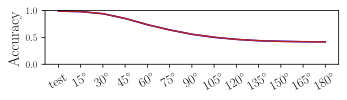

In [89]:
# make a figure for accuracy
x_labels = ['test', '15$^{\circ}$', '30$^{\circ}$', '45$^{\circ}$', '60$^{\circ}$', '75$^{\circ}$', '90$^{\circ}$',
            '105$^{\circ}$', '120$^{\circ}$', '135$^{\circ}$', '150$^{\circ}$', '165$^{\circ}$', '180$^{\circ}$']

plt.figure(figsize=(5, 1.5))
plt.plot(x_labels, Acc_D_all_mean, color='blue', label='MCMC')
plt.plot(x_labels, Acc_LB_all_mean, color='firebrick', label='LB')
plt.ylim(0,1)
plt.ylabel('Accuracy', size=15)
#plt.legend()
plt.xticks(x_labels, x_labels, rotation='30', size=13)

plt.tight_layout()

plt.savefig('figures/LB_vs_MCMC_Acc.pdf')
plt.show();

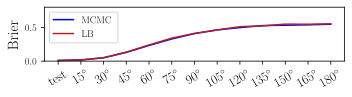

In [88]:
# make a figure for the brier score

plt.figure(figsize=(5, 1.5))
plt.plot(x_labels, Brier_D_list, color='blue', label='MCMC')
plt.plot(x_labels, Brier_LB_list, color='firebrick', label='LB')
plt.ylim(0,0.8)
plt.ylabel('Brier', size=15)
plt.legend()
plt.xticks(x_labels, x_labels, rotation='30', size=13)

plt.tight_layout()

plt.savefig('figures/LB_vs_MCMC_Brier.pdf')
plt.show();

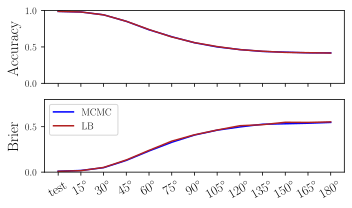

In [100]:
# make a subplot

fig, ax = plt.subplots(2, 1, figsize=(5, 3))

ax[0].plot(x_labels, Acc_D_all_mean, color='blue', label='MCMC')
ax[0].plot(x_labels, Acc_LB_all_mean, color='firebrick', label='LB')
ax[0].set_ylim(0,1)
ax[0].set_ylabel('Accuracy', size=15)
ax[0].set_xticklabels([])

ax[1].plot(x_labels, Brier_D_list, color='blue', label='MCMC')
ax[1].plot(x_labels, Brier_LB_list, color='firebrick', label='LB')
ax[1].set_ylim(0,0.8)
ax[1].set_ylabel('Brier', size=15)
ax[1].legend()
ax[1].set_xticklabels(x_labels, rotation=30, size=13)


plt.tight_layout()

plt.savefig('figures/LB_vs_MCMC_Acc_Brier.pdf')
plt.show();